<a href="https://colab.research.google.com/github/PrincetonUniversity/intro_machine_learning/blob/main/day4/intro_ml_day4_basic_cnn_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNs for Image Classification in CIFAR-10
Introduction to Machine Learning (Day 4)\
Princeton University\
Notebook by Gage DeZoort\
\
Based on the PyTorch CNN tutorial: [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)



## The CIFAR-10 Dataset


The goal of this notebook is to demo image classification in the CIFAR10 dataset using convolutional neural networks (CNNs).

If you'd like to use a GPU, click on `Runtime` (in the Colab toolbar above) then `Change runtime type` and select `T4 GPU`.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cpu" # or "cuda" if you want to use the GPU!

This tutorial is focused on the CIFAR-10 image classification dataset. "CIFAR" stands for Canadian Institute for Advanced Research, and "10" refers to the number of different image classes.
Key dataset properties include:

- 10 image classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck
- 6,000 images per class, so 60,000 images total
- 32x32 color images; each pixel is RGB, so input data will have the shape 32x32x3

Here's a quick visual :

![RGB](https://e2eml.school/images/image_processing/three_d_array.png "rgb")

![Dog](https://e2eml.school/images/image_processing/reign_pic_breakdown.png "dog")

(Images from [this blog](https://e2eml.school/convert_rgb_to_grayscale]))


Given a grid of pixels w/ RGB pixels, can we predict what the image is showing us?

The first thing we need to do is load up our dataset. Luckily, it's one of the default datasets included in `torchvision.datasets.`

In [2]:
# transform RGB features from [0,1]x3 to [-1,1]x3
transform = transforms.Compose(
  [ # image = (image - mean) / std
      transforms.ToTensor(),
      transforms.Normalize(
          (0.5, 0.5, 0.5), # means
          (0.5, 0.5, 0.5) # stds
      )
   ]
)

# grab the train and test sets
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
  )
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:02<00:00, 73.7MB/s]


With the datasets loaded, we can use the `DataLoader` class provided by torch to conveniently load up random batches of data.

In [3]:
batch_size = 4

# feed the train/test sets into data loaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)

With our loaders in place, let's plot one batch of data.

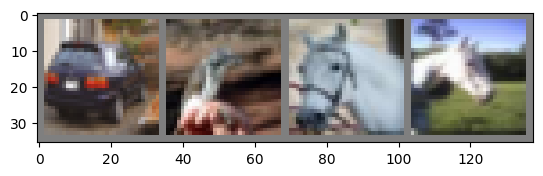

car   bird  horse horse


In [4]:
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# truth labels
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **EXERCISE 1**:

1a. (1 min) Print the shape of `images` above. Does it make sense? Are the features normalized as we expect?

In [15]:
# Exercise 1a
images.shape

torch.Size([4, 3, 32, 32])

1b. (1 min) If you only plot one feature per-pixel instead of 3, it will be interpreted as a greyscale image. Try plotting only one of the RGB features.

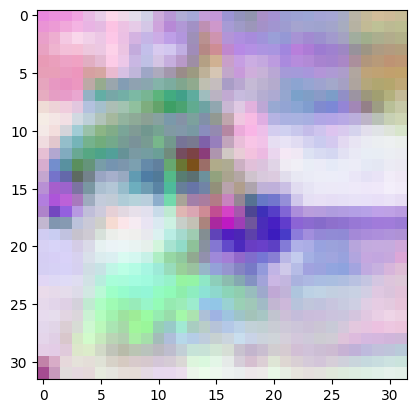

In [16]:
# Exercise 1b
# show images

imshow(torchvision.utils.make_grid(images[:,0,:,:]))


## Image Classification with a CNN

Our next goal is to define a CNN to do the image classification. The CNN will be a `torch.nn.Module`, which is a generic class designed to hold neural network components. The `forward()` function of the network is the forward pass; everything called there will be used to transform the input data (using learnable weights) and produce a prediction. The components of the forward pass are



1.   **Input Data**: 32x32x3 RGB images, visualized above.
2.   **Convolutional Layers**: Convolution is a mathematical operation that you can think about as a weighted sum. In ML, the weights are learnable, meaning that the NN adjusts them via backpropagation. The PyTorch `conv1` and `conv2` layers convolve information from a small grid of pixels and produce a "summary" of what they see. There is a [wonderful Medium article](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) that visualizes the process. Using their gifs, convolutional filters extract high level information from each RGB channel: ![Conv](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*8dx6nxpUh2JqvYWPadTwMQ.gif "conv") Information extracted from each channel is summed to a single channel: ![ConvSum](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*CYB2dyR3EhFs1xNLK8ewiA.gif "conv-sum") The filters are *learned* by the algorithm; the intuition is that they become "detectors" for certain image features. For exmaple, here's a nice example of a horizontal Sobel kernelfilter (sourced from the Medium article): ![EdgeDetector](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*wju0Urp6KpAT11wktTp5Sg.png "edge-detector")

3. **Pooling Layers**:
pooling layers are designed to downsample images. Contrary to filters, they are *not* learnable, instead representing fixed operations. For example, a pooling layer say "take the maximum value from each 3x3 grid of cells".
![Pooling](https://miro.medium.com/v2/resize:fit:588/format:webp/1*BMngs93_rm2_BpJFH2mS0Q.gif "pooling") Pooling is used to aggregate information and shape it in a useful way for downstream learning tasks.

4. **Fully-connected Layers**:
these are the simple `linear` layers you learned about last week. After convolutional filters and pooling layers have been applied, the resulting data is flattened and passed through a simple fully connected network to produce classification scores.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(6, 16, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # in_channels, out_channels
        self.fc2 = nn.Linear(120, 84) # in_channels, out_channels
        self.fc3 = nn.Linear(84, 10) # in_channels, out_channels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # learnable convolution, pool result
        x = self.pool(F.relu(self.conv2(x))) # learnable convolution, pool result
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # apply a fully-connected NN
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x # return classification scores

net = Net().to(device)
print(net.conv1)

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))


Let's make sense of the first convolution operator, `self.conv1`. Its arguments are `in_channels=3`, which makes sense because we're sending in RGB features. By default in PyTorch, all inputs are convolved to all outputs (controlled by `groups` parameter), meaning `3x6=18` filters are created. Because `kernel_size=5`, we'll be using `5x5` filters. The "stride" of the filters is by default `1`, which means they'll slide pixel-by-pixel across the image. Here's a visual of what `stride=2` might look like:

![stride2](https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_arithmetic_-_No_padding_strides.gif "stride2")

We then pool with a `2x2` pooling operator `self.pool`. The stride of the pooling operator is by default equal to its size, meaning that this pooling operation has `stride=2`.

### Exercise 2
(3 mins)  Knowing this, what is the shape of an image after the pooling stage? Can you make sense of the shapes provided to initialize `self.conv2`? What about the output of `self.conv2`?


In [18]:
image = images[0:1].to(device)
print("Initial image shape:", image.shape)
image_conv1 = net.conv1(image)
print("After conv1:", image_conv1.shape)

# TO-DO: pass image_conv1 to the pooling operator

# TO-DO: pass image_pool to the conv2 operator


Initial image shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 6, 28, 28])


Since this is a classification problem, we're going to optimize a cross entropy loss. Our strategy will be simple stochastic gradient descent.

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Here's our training loop - it's fairly standard, so we won't comment too much. Let's press play and train the network!

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.220
[1,  4000] loss: 1.863
[1,  6000] loss: 1.693
[1,  8000] loss: 1.591
[1, 10000] loss: 1.510
[1, 12000] loss: 1.456
[2,  2000] loss: 1.383
[2,  4000] loss: 1.364
[2,  6000] loss: 1.319
[2,  8000] loss: 1.298
[2, 10000] loss: 1.286
[2, 12000] loss: 1.254
Finished Training


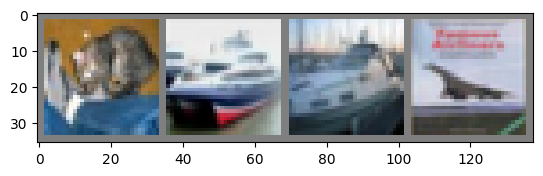

GroundTruth:  cat   ship  ship  plane


In [21]:
dataiter = iter(testloader)
test_data = next(dataiter)
images, labels = test_data[0].to(device), test_data[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [22]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.6 %
Accuracy for class: car   is 50.7 %
Accuracy for class: bird  is 39.7 %
Accuracy for class: cat   is 41.1 %
Accuracy for class: deer  is 51.5 %
Accuracy for class: dog   is 26.0 %
Accuracy for class: frog  is 73.0 %
Accuracy for class: horse is 63.0 %
Accuracy for class: ship  is 74.7 %
Accuracy for class: truck is 59.0 %


### **EXERCISE 3**

Can you improve these accuracies? Full notebook's worth of code reproduced below for convenience.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" # or "cuda" if you want to use the GPU!

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# transform RGB features from [0,1]x3 to [-1,1]x3
transform = transforms.Compose(
  [ # image = (image - mean) / std
      transforms.ToTensor(),
      transforms.Normalize(
          (0.5, 0.5, 0.5), # means
          (0.5, 0.5, 0.5) # stds
      )
   ]
)

# grab the train and test sets
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
  )
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 4

# feed the train/test sets into data loaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(6, 16, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # in_channels, out_channels
        self.fc2 = nn.Linear(120, 84) # in_channels, out_channels
        self.fc3 = nn.Linear(84, 10) # in_channels, out_channels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # learnable convolution, pool result
        x = self.pool(F.relu(self.conv2(x))) # learnable convolution, pool result
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # apply a fully-connected NN
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x # return classification scores

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Solutions to Exercises


```
#Exercise 1a

# returns [4, 3, 32, 32], corresponding to [batch_size, RGB, ix, iy]
images.shape
```

```
# Exercise 1b

# plot the "R" features only as greyscale
imshow(torchvision.utils.make_grid(images[:,0:1,:,:]))
```

```
Exercise 2

# 2. (3 mins)  Knowing this, what is the shape of an image after the pooling stage? Can you make sense of the shapes provided to initialize `self.conv2`? What about the output of `self.conv2`?

image = images[0:1].to(device)
print("Initial image shape:", image.shape)
image_conv1 = net.conv1(image)
print("After conv1:", image_conv1.shape)
image_pool = net.pool(image_conv1)
print("After pooling:", image_pool.shape)
image_conv2 = net.conv2(image_pool)
print("After conv2:", image_conv2.shape)

```